# Data Loading and Dataset Creation

In [ ]:
from glob import glob
import os
import cv2 as cv
import matplotlib.pyplot as plt
import tifffile
import numpy as np
import tensorflow as tf

In [ ]:
data_path='/content/drive/MyDrive/Data/polyp/CVC-ClinicDB'

In [ ]:
def read_Image(tiff_path):
  img = tifffile.imread(tiff_path)
  img=cv.resize(img,(256,256))
  img=img/255.0
  return img

In [ ]:
def read_Mask(path):
  mask=cv.imread(path,cv.IMREAD_GRAYSCALE)
  mask=cv.resize(mask,(256,256))
  mask=mask/255.0
  return mask

In [ ]:
def create_dataset(images_folder, masks_folder):
    images,masks=[],[]
    images = [read_Image(image_path) for image_path in images_folder]
    masks = [read_Mask(mask_path) for mask_path in masks_folder]

    dataset = tf.data.Dataset.from_tensor_slices((images, masks))
    dataset = dataset.shuffle(len(dataset))

    return dataset

In [ ]:
def load_data(dataset,split=0.1):
  # Calculate the sizes of the subsets
  data_size = len(dataset)
  val_size = int(data_size * split)
  test_size = int(data_size * split)
  train_size = data_size - val_size - test_size
  print(data_size,train_size,val_size,test_size)

  # Split the dataset
  train_set = dataset.take(train_size)
  val_set = dataset.skip(train_size).take(val_size)
  test_set = dataset.skip(train_size + val_size)

  return train_set, val_set, test_set

In [ ]:
def batch_data(dataset,batch_size=8):
  dataset=dataset.batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)
  return dataset

In [ ]:
images_folder = sorted(glob(data_path+'/Original/*.tif'))
masks_folder = sorted(glob(data_path+'/Ground Truth/*.tif'))

dataset = create_dataset(images_folder, masks_folder)

In [ ]:
train_set, val_set, test_set = load_data(dataset)

612 490 61 61


In [ ]:
def plot_images_and_masks(dataset, num_samples=5):
    plt.figure(figsize=(15, num_samples))
    for i, (image, mask) in enumerate(dataset.take(num_samples)):
        plt.subplot(2, num_samples, i+1)
        plt.imshow(image.numpy())
        plt.title("Image")
        plt.axis('off')
        plt.subplot(2, num_samples, i+num_samples+1)
        plt.imshow(mask.numpy(), cmap='gray')
        plt.title("Mask")
        plt.axis('off')
    plt.show()

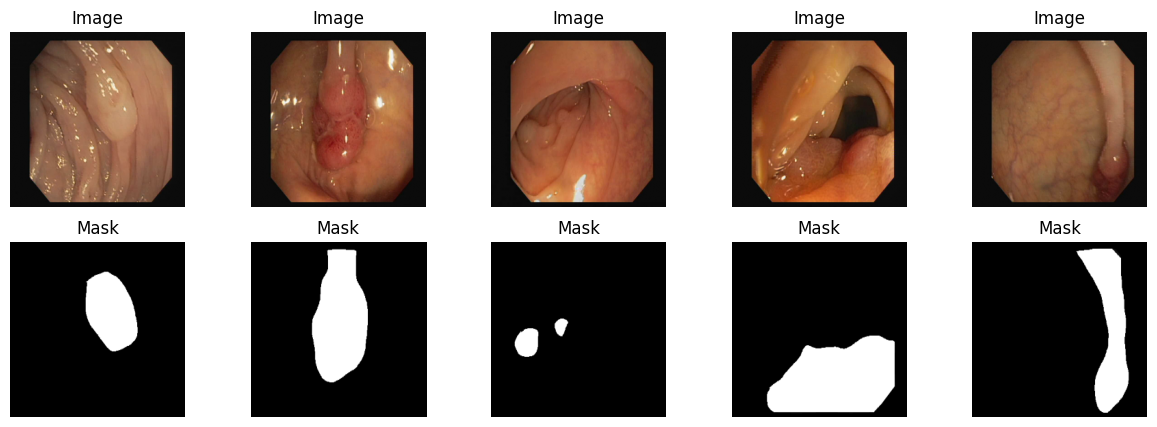

In [ ]:
plot_images_and_masks(train_set)

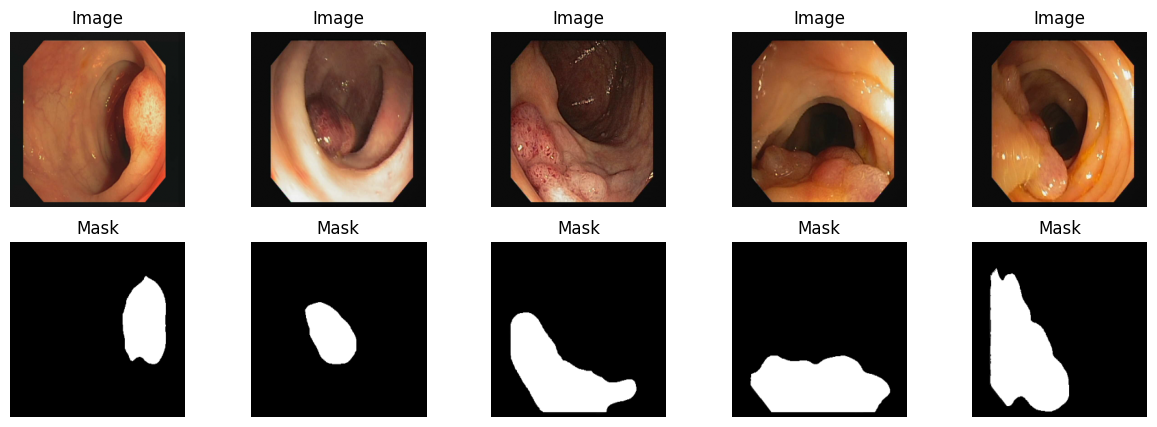

In [ ]:
plot_images_and_masks(val_set)

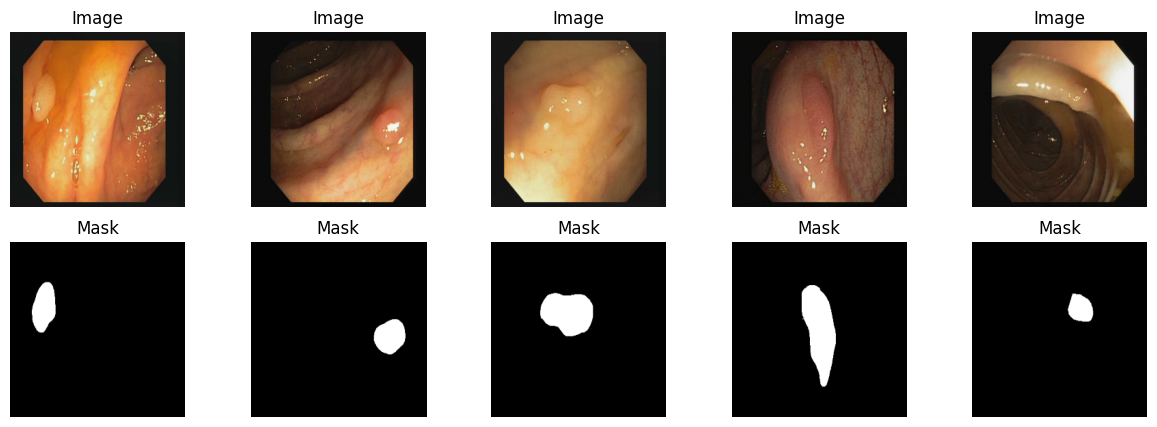

In [ ]:
plot_images_and_masks(test_set)

In [ ]:
batch_size=8
train_set=batch_data(train_set,batch_size)
val_set=batch_data(val_set,batch_size)
test_set=batch_data(test_set,batch_size)

In [ ]:
train_set

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float64, name=None), TensorSpec(shape=(None, 256, 256), dtype=tf.float64, name=None))>

In [ ]:
val_set

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float64, name=None), TensorSpec(shape=(None, 256, 256), dtype=tf.float64, name=None))>

In [ ]:
test_set

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float64, name=None), TensorSpec(shape=(None, 256, 256), dtype=tf.float64, name=None))>

# The Model

## Building The Model

In [ ]:
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, CSVLogger, TensorBoard

In [ ]:
model_path='/content/drive/MyDrive/Data/polyp/model'

In [ ]:
def unet_model():
  inputs = Input(shape=(256,256,3))

  # Encoder
  conv1 = Conv2D(64, 3, activation='relu', padding='same')(inputs)
  conv1 = BatchNormalization()(conv1)
  conv1 = Conv2D(64, 3, activation='relu', padding='same')(conv1)
  conv1 = BatchNormalization()(conv1)
  pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

  conv2 = Conv2D(128, 3, activation='relu', padding='same')(pool1)
  conv2 = BatchNormalization()(conv2)
  conv2 = Conv2D(128, 3, activation='relu', padding='same')(conv2)
  conv2 = BatchNormalization()(conv2)
  pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

  conv3 = Conv2D(256, 3, activation='relu', padding='same')(pool2)
  conv3 = BatchNormalization()(conv3)
  conv3 = Conv2D(256, 3, activation='relu', padding='same')(conv3)
  conv3 = BatchNormalization()(conv3)
  pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

  # Bridge
  bridge = Conv2D(512,1,activation='relu', padding='same')(pool3)
  bridge = BatchNormalization()(bridge)
  bridge = Conv2D(512,1,activation='relu', padding='same')(bridge)
  bridge = BatchNormalization()(bridge)

  # Decoder
  up1 = Conv2DTranspose(256,(2,2),strides=(2,2),padding='same')(bridge)
  merge1 = Concatenate(axis=3)([up1, conv3])
  up1 = Conv2D(256, 3, activation='relu', padding='same')(merge1)
  up1 = BatchNormalization()(up1)
  up1 = Conv2D(256, 3, activation='relu', padding='same')(up1)
  up1 = BatchNormalization()(up1)

  up2 = Conv2DTranspose(128,(2,2),strides=(2,2),padding='same')(up1)
  merge2 = Concatenate(axis=3)([up2, conv2])
  up2 = Conv2D(128, 3, activation='relu', padding='same')(merge2)
  up2 = BatchNormalization()(up2)
  up2 = Conv2D(128, 3, activation='relu', padding='same')(up2)
  up2 = BatchNormalization()(up2)

  up3 = Conv2DTranspose(64,(2,2),strides=(2,2),padding='same')(up2)
  merge3 = Concatenate(axis=3)([up3, conv1])
  up3 = Conv2D(64, 3, activation='relu', padding='same')(merge3)
  up3 = BatchNormalization()(up3)
  up3 = Conv2D(64, 3, activation='relu', padding='same')(up3)
  up3 = BatchNormalization()(up3)

  # Output layer
  outputs = Conv2D(1, 1, activation='sigmoid')(up3)

  model = tf.keras.Model(inputs=inputs, outputs=outputs)

  return model

model = unet_model()
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d_15 (Conv2D)          (None, 256, 256, 64)         1792      ['input_2[0][0]']             
                                                                                                  
 batch_normalization_14 (Ba  (None, 256, 256, 64)         256       ['conv2d_15[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 conv2d_16 (Conv2D)          (None, 256, 256, 64)         36928     ['batch_normalization_14

In [ ]:
def iou(y_true, y_pred):
    def f(y_true, y_pred):
        intersection = (y_true * y_pred).sum()
        union = y_true.sum() + y_pred.sum() - intersection
        x = (intersection + 1e-15) / (union + 1e-15)
        x = x.astype(np.float32)
        return x
    return tf.numpy_function(f, [y_true, y_pred], tf.float32)

## Training

In [ ]:
callbacks = [
          ModelCheckpoint(model_path+'/model.h5'),
          ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3),
          CSVLogger(model_path+'/data.csv'),
          TensorBoard(),
          EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=False)
     ]

In [ ]:
epochs=30
learning_rate=0.0001

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

# Compile the model
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy',tf.keras.metrics.Recall(),tf.keras.metrics.Precision(),iou])

In [93]:
history = model.fit(train_set, epochs=epochs, validation_data=val_set, callbacks=callbacks)

Epoch 1/30
62/62 [==============================] - 27s 430ms/step - loss: 0.1161 - accuracy: 0.9529 - recall_1: 0.6354 - precision_1: 0.8203 - iou: 0.4348 - val_loss: 0.1100 - val_accuracy: 0.9575 - val_recall_1: 0.6632 - val_precision_1: 0.8754 - val_iou: 0.4677 - lr: 1.0000e-06
Epoch 2/30
62/62 [==============================] - 26s 412ms/step - loss: 0.1217 - accuracy: 0.9503 - recall_1: 0.6171 - precision_1: 0.8544 - iou: 0.4429 - val_loss: 0.1114 - val_accuracy: 0.9560 - val_recall_1: 0.6882 - val_precision_1: 0.8357 - val_iou: 0.4617 - lr: 1.0000e-06
Epoch 3/30
62/62 [==============================] - 25s 404ms/step - loss: 0.1193 - accuracy: 0.9509 - recall_1: 0.6217 - precision_1: 0.8380 - iou: 0.4385 - val_loss: 0.1133 - val_accuracy: 0.9550 - val_recall_1: 0.6269 - val_precision_1: 0.8185 - val_iou: 0.4306 - lr: 1.0000e-06
Epoch 4/30
62/62 [==============================] - 26s 418ms/step - loss: 0.1233 - accuracy: 0.9498 - recall_1: 0.6110 - precision_1: 0.8320 - iou: 0.431

In [94]:
model.evaluate(test_set)

8/8 [==============================] - 1s 117ms/step - loss: 0.1143 - accuracy: 0.9530 - recall_1: 0.6678 - precision_1: 0.8574 - iou: 0.4826


[0.11428327858448029,
 0.952967643737793,
 0.6677704453468323,
 0.8573583364486694,
 0.4826142191886902]

# Testing

In [105]:
test_save_path='/content/drive/MyDrive/Data/polyp/model/Test_Images'

In [106]:
i=0
for image, mask in test_set:
    # Predict mask using your trained model
    predicted_mask = model.predict(image)

    # Convert image, mask, and predicted_mask to NumPy arrays
    image_np = image.numpy()[0]
    mask_np = mask.numpy()[0]    
    predicted_mask_np = predicted_mask[0]  

    # Apply threshold to the predicted mask
    threshold = 0.5
    predicted_mask_np = (predicted_mask_np > threshold).astype(np.uint8)

    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    axes[0].imshow(image_np)
    axes[0].set_title('Original Image')
    axes[0].axis('off')

    axes[1].imshow(mask_np, cmap='gray')
    axes[1].set_title('Ground Truth Mask')
    axes[1].axis('off')

    axes[2].imshow(predicted_mask_np, cmap='gray')
    axes[2].set_title('Predicted Mask')
    axes[2].axis('off')

    # Save the combined image
    plt.savefig(test_save_path+'image_mask_prediction{}.png'.format(i))
    plt.close()
    i+=1

1/1 [==============================] - 0s 26ms/step


# Save the model

In [110]:
model_path = '/content/drive/MyDrive/Data/polyp/'

In [111]:
model.save(model_path+'model.h5')